# Text-to-Image Generation with Stable Diffusion and OpenVINO™

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It is trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

Model capabilities are not limited text-to-image only, it also is able solve additional tasks, for example text-guided image-to-image generation and inpainting. This tutorial also considers how to run text-guided image-to-image generation using Stable Diffusion.


This notebook demonstrates how to convert and run stable diffusion model using OpenVINO. For user experience simplification, we will use  [Hugging Face Optimum](https://huggingface.co/docs/optimum/installation) library accelerated by OpenVINO integration for model conversion and [OpenVINO GenAI API](https://docs.openvino.ai/2024/learn-openvino/llm_inference_guide/genai-guide.html) for model inference.



#### Table of contents:

- [Prerequisites](#Prerequisites)
- - [Convert model using Optimum-CLI tool](#Convert-model-using-Optimum-CLI-tool)
- [Prepare Inference Pipelines](#Prepare-Inference-Pipelines)
- [Text-to-image pipeline](#Text-to-image-pipeline)
    - [Text-to-Image generation](#Text-to-Image-generation)


## Prerequisites


In [1]:
import platform

%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "diffusers>=0.30.0" "torch>=2.1"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "huggingface-hub>=0.9.1" Pillow opencv-python tqdm "gradio>=4.19"
%pip install -qU "openvino>=2025.0" "openvino_genai>=2025.0" "openvino_tokenizers>=2025.0"

if platform.system() == "Darwin":
    %pip install -q "numpy<2.0"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Fetch `notebook_utils` module
import requests
from pathlib import Path

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)


if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )

    open("cmd_helper.py", "w").write(r.text)

from notebook_utils import download_file, device_widget

if not Path("gradio_helper.py").exists():
    download_file(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-text-to-image/gradio_helper.py")

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("stable-diffusion-text-to-image.ipynb")

## Convert model using Optimum-CLI tool


🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries and OpenVINO to accelerate end-to-end pipelines on Intel architectures. It provides ease-to-use cli interface for exporting models to [OpenVINO Intermediate Representation (IR)](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) format.


In [4]:
from cmd_helper import optimum_cli

MODEL_ID = "prompthero/openjourney"
MODEL_DIR = Path("diffusion_pipeline")


if not MODEL_DIR.exists():
    optimum_cli(MODEL_ID, MODEL_DIR, additional_args={"weight-format": "fp16"})

**Export command:**

`optimum-cli export openvino --model prompthero/openjourney diffusion_pipeline --weight-format fp16`

## Text-to-image pipeline
[back to top ⬆️](#Table-of-contents:)

`openvino_genai.Text2ImagePipeline` represents inference pipeline for text-to-image generation. For creation pipeline instance, you should provide directory with converted to OpenVINO model and inference device.

When Stable Diffusion models are exported to the OpenVINO format, they are decomposed into three components that consist of four models combined during inference into the pipeline:

* The text encoder
    * The text-encoder is responsible for transforming the input prompt(for example "a photo of an astronaut riding a horse") into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.
* The U-NET
    * Model predicts the `sample` state for the next step.
* The VAE encoder
    * The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model (used only for image-to-image and inpainting tasks).
* The VAE decoder
    * The decoder transforms the latent representation back into an image.

Select device from dropdown list for running inference using OpenVINO.

In [5]:
device = device_widget()
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [6]:
import openvino_genai as ov_genai
from PIL import Image
from tqdm.notebook import tqdm
import sys

DEVICE = device.value

pipe = ov_genai.Text2ImagePipeline(MODEL_DIR, DEVICE)

### Text-to-Image generation
[back to top ⬆️](#Table-of-contents:)

Now, you can define a text prompt for image generation and run inference pipeline.

> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.

In [12]:
import ipywidgets as widgets

sample_text = (
    "A sleek and modern gym named 'AG Fitness' with a bold black and gold color scheme. The gym features high-end workout equipment, large mirrors, and a well-lit, spacious environment. The AG Fitness logo, designed with the letters A and G forming a person lifting weights, is prominently displayed on the wall. The atmosphere is energetic, with people engaging in weightlifting, cardio, and functional training. The scene exudes a premium, motivational, and fitness-focused vibe."
)
text_prompt = widgets.Text(value=sample_text, description="your text")
num_steps = widgets.IntSlider(min=1, max=50, value=20, description="steps:")
seed = widgets.IntSlider(min=0, max=10000000, description="seed: ", value=42)
widgets.VBox([text_prompt, num_steps, seed])

In [13]:
print("Pipeline settings")
print(f"Input text: {text_prompt.value}")
print(f"Seed: {seed.value}")
print(f"Number of steps: {num_steps.value}")

Pipeline settings
Input text: A sleek and modern gym named 'AG Fitness' with a bold black and gold color scheme. The gym features high-end workout equipment, large mirrors, and a well-lit, spacious environment. The AG Fitness logo, designed with the letters A and G forming a person lifting weights, is prominently displayed on the wall. The atmosphere is energetic, with people engaging in weightlifting, cardio, and functional training. The scene exudes a premium, motivational, and fitness-focused vibe.
Seed: 42
Number of steps: 20


Let's generate an image and save the generation results.
The pipeline returns one or several results: `images` contains final generated image. To get more than one result, you can set the `num_images_per_prompt` parameter.

In [14]:
random_generator = ov_genai.TorchGenerator(seed.value)

pbar = tqdm(total=num_steps.value)


def callback(step, num_steps, latent):
    if num_steps != pbar.total:
        pbar.reset(num_steps)
    pbar.update(1)
    sys.stdout.flush()
    return False


result = pipe.generate(text_prompt.value, num_inference_steps=num_steps.value, generator=random_generator, callback=callback)

pbar.close()

final_image = Image.fromarray(result.data[0])
final_image.save("result.png")

  0%|          | 0/20 [00:00<?, ?it/s]

Now is show time!

Input text:
	A sleek and modern gym named 'AG Fitness' with a bold black and gold color scheme
	 The gym features high-end workout equipment, large mirrors, and a well-lit, spacious environment
	 The AG Fitness logo, designed with the letters A and G forming a person lifting weights, is prominently displayed on the wall
	 The atmosphere is energetic, with people engaging in weightlifting, cardio, and functional training
	 The scene exudes a premium, motivational, and fitness-focused vibe
	


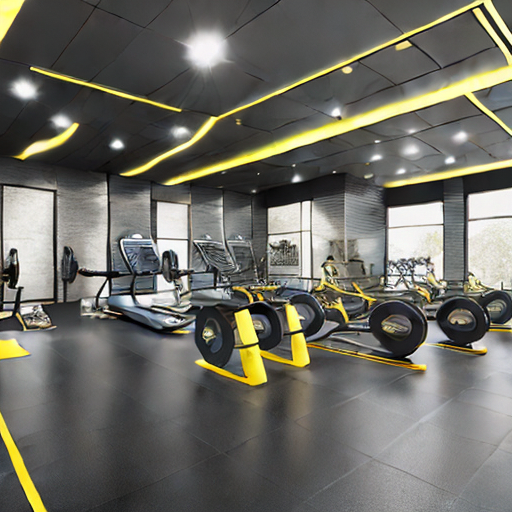

In [15]:
text = "\n\t".join(text_prompt.value.split("."))
print("Input text:")
print("\t" + text)
display(final_image)